# Обучение с учителем (модели типа "черный ящик")

Рассмотрим пример турбулентного течения вокруг крыла. Задача состоит в моделировании средних значений скорости и распределение поля давлени вокруг крыла для различных значений числа Рейнольдса и различных значений углов атаки. Таким образом, для заданной формы крыла, значения числа Рейнольдса и угла атаки необходимо получить поле скорости и поле давления вокруг крыла.

Эта задача традиционно решается с помощью уравнение Навье-Стокса, осредненных по Рейнольдсу, и является одним из наиболее известных приложений уравнений Навье-Стокса для промышленности. Однако вмсето того, чтобы использовать классический численный метод, наша целью состоит в обучении суррогатной модели с помощью нейронной сети, которая не полагается на классический симулятор, и обеспечивает возможность расчета скоростей и давления.  

## Формализация задачи

Обучение с учителей предполагает решение следующей задачи:

$$\begin{aligned}
\text{arg min}_{\theta} \sum_i ( f(x_i ; \theta)-y^*_i )^2 ,
\end{aligned}$$

где $x$ и $y^*$ означает множества физических полей,
а под индексом $i$ оценивается разница по всем дискретным значением в исходном множестве.

Цель решения задачи заключается в том, чтобы рассчитать поля скорости $\mathbf{u} = u_x,u_y$ и давления $p$ в области $\Omega$ вокруг крыла в центре $\Omega$. 
$u_x,u_y$ и $p$ каждая имеет размерность $128^2$.
В качестве исходных данных используется число Рейнольдса $\text{Re} \in \mathbb{R}$, угол атаки
$\alpha \in \mathbb{R}$, профиль крыла $\mathbf{s}$ кодированный с помощью растерной сетки $128^2$.
 $\text{Re}$ и $\alpha$ приведены в пересчете на скорость свободного потока $\mathbf{f}$, x и y представляют собой поля постоянного размера, и содержат нули в области крыла.
То есть входные и выходные переменные имеют одинаковую размерность: $x,y^* \in \mathbb{R}^{3\times128\times128}$. Вход включает 
$[f_x,f_y,\text{mask}]$, выходные переменные $[p,u_x,u_y]$.
Это то, что будет являться входами и выходами нейронной сети.

Переменные $y^*$ содержит три физических поля. Компоненты скорости близкие друг к другу, но поле давления имеет иное поведение приблизительно как квадрат давления (cf. [Бернулли](https://en.wikipedia.org/wiki/Bernoulli%27s_principle)). Это значит, что для обучения нейронной сети необходимо выполнить нормализацию данных.

Код адаптирован из {cite}`thuerey2020dfp` и [этого репозитория](https://github.com/thunil/Deep-Flow-Prediction). Здесь мы будем использовать небольшу.ю выборку данных, сгенерированную с помощью Spalart-Almaras RANS в [OpenFOAM](https://openfoam.org/).

In [8]:
import numpy as np
import os.path, random
import torch
from torch.utils.data import Dataset

print(f"Torch version: {torch.__version__}")

# получение данных

Torch version: 2.0.1


In [13]:
dir = "./"
if not os.path.isfile('data-airfoils.npz'):
    import requests
    print("Скачивание данных (~300Мб)...")
    with open('data-airfoils.npz', 'wb') as datafile:
        resp = requests.get('https://dataserv.ub.tum.de/s/m1615239/download?path=%2F&files=dfp-data-400.npz', verify=False)
        datafile.write(resp.content)        
    
npfile = np.load(dir + 'data-airfoils.npz')
    
print(f"Данные загружены, {len(npfile['inputs'])} обучающих, {len(npfile['vinputs'])} валидационных примеров")
print(f"Размер входного массива: {npfile['inputs'].shape}")

Данные загружены, 320 обучающих, 80 валидационных примеров
Размер входного массива: (320, 3, 128, 128)


## Исследование данных

Статистика 0: [-0.3255776199086798, 0.23393399824079095, 0.47048169549735686]
Статистика 1: [-0.6548143700240462, 0.017164150495987723, 0.8552243695079386]
Статистика 2: [-0.5325950274411584, -0.04987998400700594, 1.0]


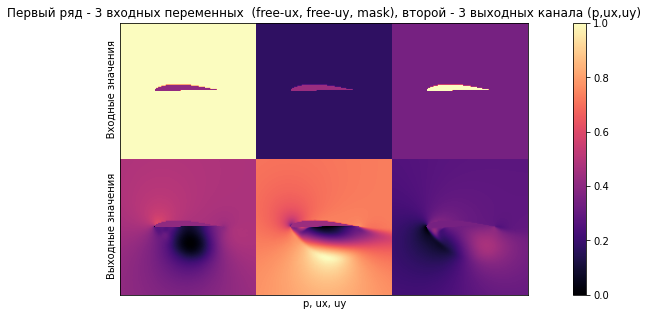

In [32]:
import pylab

def showSbs(a1, a2, stats=False, bottom="NN Output", top="Reference", title=None): 
    c = []
    for i in range(3):
        b = np.flipud(np.concatenate((a2[i], a1[i]), axis=1).transpose())
        min, mean, max = np.min(b), np.mean(b), np.max(b); 
        if stats: 
            print("Статистика %d: "%i + format([min, mean, max]))
        
        b -= min; 
        b /= (max-min)
        c.append(b)
    
    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    axes.set_xticks([]); 
    axes.set_yticks([]); 
    im = axes.imshow(np.concatenate(c, axis=1), origin='upper', cmap='magma')

    pylab.colorbar(im); 
    pylab.xlabel('p, ux, uy'); 
    pylab.ylabel('%s           %s'%(bottom,top))
    if title is not None: pylab.title(title)

NUM = 72
showSbs(npfile["inputs"][NUM], npfile["targets"][NUM], 
        stats=True, 
        bottom="Выходные значения", 
        top="Входные значения", 
        title="Первый ряд - 3 входных переменных  (free-ux, free-uy, mask), второй - 3 выходных канала (p,ux,uy)")


## Задание констант

In [31]:
npfile["inputs"][NUM].shape

(3, 128, 128)

In [46]:
EPOCHS = 100
BATCH_SIZE = 10
LR = 2e-5

class DfpDataset():
    def __init__(self, inputs,targets): 
        self.inputs  = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    
    
tdata = DfpDataset(npfile["inputs"], npfile["targets"])
vdata = DfpDataset(npfile["vinputs"], npfile["vtargets"])

trainLoader = torch.utils.data.DataLoader(tdata, batch_size=BATCH_SIZE, shuffle=True , drop_last=True) 
valiLoader  = torch.utils.data.DataLoader(vdata, batch_size=BATCH_SIZE, shuffle=False, drop_last=True) 

print("Тестовый и валидационный батч: {} , {}".format(len(trainLoader),len(valiLoader) ))

Тестовый и валидационный батч: 32 , 8


## Архитектура нейронной сети

Будем использовать архитектуру нейронной сети U-net. Это широко используемая архитектура, которая использует набор сверток по разным пространственным координатам. Основное отличие от обычной сверточной сети заключается в использовании _skip connection_ от кодера к декодеру. Это обеспечивает сохранность информации, извлекаемой при формировании признакового пространства. 
 
Архитектура имеет следующий вид:

![Архитектура U-net](res/supervised-airfoils-unet.jpg)

Определим блок свертки `blockUNet`. Мы не используем пулинг, следуя [лучшим практикам](https://distill.pub/2016/deconv-checkerboard/). Класс `DfpNet` используется для описания нейронной сети.

In [47]:
import os, sys, random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd 
import torch.utils.data 

def blockUNet(in_c, out_c, name, size=4, pad=1, transposed=False, bn=True, activation=True, relu=True, dropout=0. ):
    block = nn.Sequential()

    if not transposed:
        block.add_module('%s_conv' % name, nn.Conv2d(in_c, out_c, kernel_size=size, stride=2, padding=pad, bias=True))
    else:
        block.add_module('%s_upsam' % name, nn.Upsample(scale_factor=2, mode='bilinear'))
        # reduce kernel size by one for the upsampling (ie decoder part)
        block.add_module('%s_tconv' % name, nn.Conv2d(in_c, out_c, kernel_size=(size-1), stride=1, padding=pad, bias=True))

    if bn:
        block.add_module('%s_bn' % name, nn.BatchNorm2d(out_c))
    if dropout>0.:
        block.add_module('%s_dropout' % name, nn.Dropout2d( dropout, inplace=True))

    if activation:
        if relu:
            block.add_module('%s_relu' % name, nn.ReLU(inplace=True))
        else:
            block.add_module('%s_leakyrelu' % name, nn.LeakyReLU(0.2, inplace=True))

    return block
    
class DfpNet(nn.Module):
    def __init__(self, channelExponent=6, dropout=0.):
        super(DfpNet, self).__init__()
        channels = int(2 ** channelExponent + 0.5)

        self.layer1 = blockUNet(3         , channels*1, 'enc_layer1', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer2 = blockUNet(channels  , channels*2, 'enc_layer2', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer3 = blockUNet(channels*2, channels*2, 'enc_layer3', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer4 = blockUNet(channels*2, channels*4, 'enc_layer4', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer5 = blockUNet(channels*4, channels*8, 'enc_layer5', transposed=False, bn=True, relu=False, dropout=dropout ) 
        self.layer6 = blockUNet(channels*8, channels*8, 'enc_layer6', transposed=False, bn=True, relu=False, dropout=dropout , size=2,pad=0)
        self.layer7 = blockUNet(channels*8, channels*8, 'enc_layer7', transposed=False, bn=True, relu=False, dropout=dropout , size=2,pad=0)
     
        # note, kernel size is internally reduced by one for the decoder part
        self.dlayer7 = blockUNet(channels*8, channels*8, 'dec_layer7', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer6 = blockUNet(channels*16,channels*8, 'dec_layer6', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer5 = blockUNet(channels*16,channels*4, 'dec_layer5', transposed=True, bn=True, relu=True, dropout=dropout ) 
        self.dlayer4 = blockUNet(channels*8, channels*2, 'dec_layer4', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer3 = blockUNet(channels*4, channels*2, 'dec_layer3', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer2 = blockUNet(channels*4, channels  , 'dec_layer2', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer1 = blockUNet(channels*2, 3         , 'dec_layer1', transposed=True, bn=False, activation=False, dropout=dropout )

    def forward(self, x):
        # note, this Unet stack could be allocated with a loop, of course... 
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        out7 = self.layer7(out6)
        # ... bottleneck ...
        dout6 = self.dlayer7(out7)
        dout6_out6 = torch.cat([dout6, out6], 1)
        dout6 = self.dlayer6(dout6_out6)
        dout6_out5 = torch.cat([dout6, out5], 1)
        dout5 = self.dlayer5(dout6_out5)
        dout5_out4 = torch.cat([dout5, out4], 1)
        dout4 = self.dlayer4(dout5_out4)
        dout4_out3 = torch.cat([dout4, out3], 1)
        dout3 = self.dlayer3(dout4_out3)
        dout3_out2 = torch.cat([dout3, out2], 1)
        dout2 = self.dlayer2(dout3_out2)
        dout2_out1 = torch.cat([dout2, out1], 1)
        dout1 = self.dlayer1(dout2_out1)
        return dout1

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


Параметр `EXPO` контролирует признаковое пространство Unet: напрямую масштабирует сеть (3 ведет к числу параметров ~150k ). Это довольно мало для сети с $3 \times 128^2 = \text{ca. }49k$ выходами, но позволяет быстро обучить сеть и позволяет избежать переобучения даже на нашей относительно небольшой выборке. Это неплохая точка старта.

In [48]:
# channel exponent to control network size
EXPO = 3

# setup network
net = DfpNet(channelExponent=EXPO)
#print(net) # to double check the details...

nn_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in nn_parameters])

# crucial parameter to keep in view: how many parameters do we have?
print(f"Количество параметров сети: {params}") 

net.apply(weights_init)

criterionL1 = nn.L1Loss()
optimizerG = optim.Adam(net.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=0.0)

targets = torch.autograd.Variable(torch.FloatTensor(BATCH_SIZE, 3, 128, 128))
inputs  = torch.autograd.Variable(torch.FloatTensor(BATCH_SIZE, 3, 128, 128))


Количество параметров сети: 147363


## Обучение сети

Обучение по 320 примеров 100 раз.

In [49]:
history_L1 = []
history_L1val = []

# if os.path.isfile("network"):
#   print("Найдена ранее сохраненная сеть, загрузка, обучение не проводится")
#   net.load_state_dict(torch.load("network"))

else:
  print("Обучение...")
  for epoch in range(EPOCHS):
      net.train()
      L1_accum = 0.0
      for i, traindata in enumerate(trainLoader, 0):
          inputs_curr, targets_curr = traindata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          net.zero_grad()
          gen_out = net(inputs)

          lossL1 = criterionL1(gen_out, targets)
          lossL1.backward()
          optimizerG.step()
          L1_accum += lossL1.item()

      # validation
      net.eval()
      L1val_accum = 0.0
      for i, validata in enumerate(valiLoader, 0):
          inputs_curr, targets_curr = validata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          outputs = net(inputs)
          outputs_curr = outputs.data.cpu().numpy()

          lossL1val = criterionL1(outputs, targets)
          L1val_accum += lossL1val.item()

      # data for graph plotting
      history_L1.append( L1_accum / len(trainLoader) )
      history_L1val.append( L1val_accum / len(valiLoader) )

      if epoch<3 or epoch%20==0:
          print( "Эпоха: {}, L1 train: {:7.5f}, L1 val: {:7.5f}".format(epoch, history_L1[-1], history_L1val[-1]) )

#   torch.save(net.state_dict(), "network" )
  print("Обучение завершено")


Training from scratch
Epoch: 0, L1 train: 0.25850, L1 vali: 0.20864
Epoch: 1, L1 train: 0.23144, L1 vali: 0.20013
Epoch: 2, L1 train: 0.21010, L1 vali: 0.18740
Epoch: 20, L1 train: 0.05054, L1 vali: 0.04306
Epoch: 40, L1 train: 0.03717, L1 vali: 0.02908
Epoch: 60, L1 train: 0.03232, L1 vali: 0.02538
Epoch: 80, L1 train: 0.03202, L1 vali: 0.02399
Training done, saved network


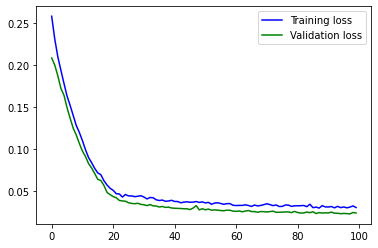

In [50]:
import matplotlib.pyplot as plt

l1train = np.asarray(history_L1)
l1vali  = np.asarray(history_L1val)

plt.plot(np.arange(l1train.shape[0]),l1train,'b',label='Training loss')
plt.plot(np.arange(l1vali.shape[0] ),l1vali ,'g',label='Validation loss')
plt.legend()
plt.show()


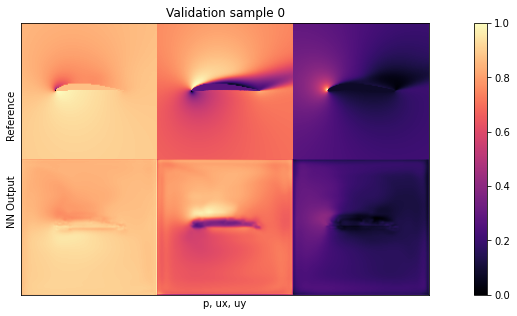

In [51]:
net.eval()
for i, validata in enumerate(valiLoader, 0):
    inputs_curr, targets_curr = validata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())
    
    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()
    if i<1: showSbs(targets_curr[0] , outputs_curr[0], title="Validation sample %d"%(i*BATCH_SIZE))


## Тестирование сети

Loaded 10/10 test samples


Average test error: 0.027650449890643358


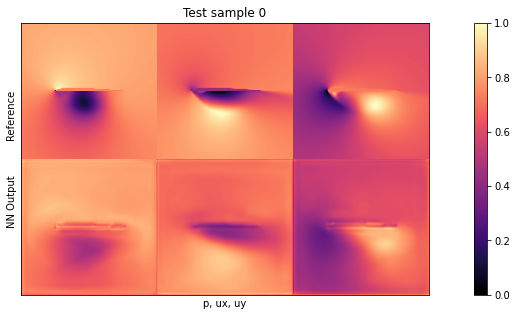

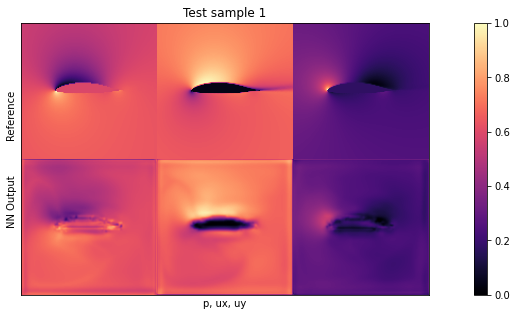

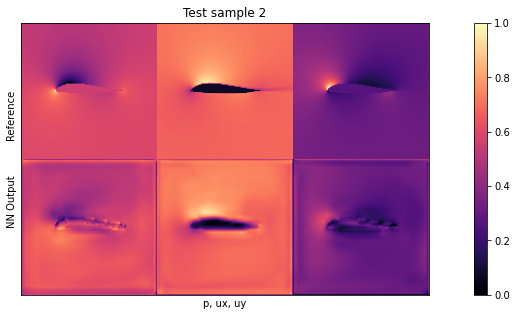

In [52]:
if not os.path.isfile('data-airfoils-test.npz'):
  import urllib.request
  url="https://physicsbaseddeeplearning.org/data/data_test.npz"
  print("Downloading test data, this should be fast...")
  urllib.request.urlretrieve(url, 'data-airfoils-test.npz')

nptfile=np.load('data-airfoils-test.npz')
print("Loaded {}/{} test samples\n".format(len(nptfile["test_inputs"]),len(nptfile["test_targets"])))

testdata = DfpDataset(nptfile["test_inputs"],nptfile["test_targets"])
testLoader  = torch.utils.data.DataLoader(testdata, batch_size=1, shuffle=False, drop_last=True) 

net.eval()
L1t_accum = 0.
for i, validata in enumerate(testLoader, 0):
    inputs_curr, targets_curr = validata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())

    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()

    lossL1t = criterionL1(outputs, targets)
    L1t_accum += lossL1t.item()
    if i<3: showSbs(targets_curr[0] , outputs_curr[0],  title="Test sample %d"%(i))

print("\nAverage test error: {}".format( L1t_accum/len(testLoader) ))

Средняя ошибка на тестовой выборке составляет 0.03. С учетом того, что данные нормализованы, это значает, что ошибка составляет около 3% по отношению к максимальному значению по каждому из полей.

На рисунках видно, что пики высоких значений давления и выскокие скорости не моделируются. Это вызвано, прежде всего, небольшим размером сети.

Однако мы заменили сложный симулятор на относительно небольшую нейронную сеть. Она имеет поддержку GPU, она дифференцируема, и точность довольно высокая.